# Analysing the red hair phenotype in the UK Biobank with epiTree

As a test case, we considered the red hair phenotype in UK Biobank data. Details on this analysis can be found in our manuscript: 

Behr M, Kumbier K, Cordova-Palomera A, Matthew Aguirre M, Ashley E, Butte E, Arnaout R, Brown B, Priest J†, Yu B† (2020)
**Learning epistatic polygenic phenotypes with boolean interactions**

All our output files for this analysis are uploaded in the the *results* folder of this repository. Given access to the UK Biobank data (available from UK Biobank under some licence agreement, see <https://www.ukbiobank.ac.uk/principles-of-access/> and data availablity statement in our manuscript), one can reproduce these output results files by following the step-by-step instructions given in the README file of this repository.  

In the following, we demonstrate how to reproduce the major figures of our manuscript.

In [1]:
setwd('./scripts')

## iRF candidate interactions

First, we consider the results from the iRF candiate interaction selection step.
The gene level iRF model *fit* (and its two competitors: *frang* (regular Random Forest obtained with the R package ranger) and *lasso* (penalized logistic regression, with L1 penalty)), which was obtained from training data, can be loaded as follows. For the SNP level model, replace "gene" by "SNP".

In [2]:
load("../results/analysis_iRF_gene.Rdata") #load the iRF model
load("../results/lasso_analysis_iRF_gene.Rdata") #load the lasso model
load("../results/ranger_analysis_iRF_gene.Rdata") #load the ranger model

Here, we considered a balanced training and test set of size 26K and 4K, respectively, see, e.g., the scripts *analysis_iRF_gene.R* and *analysis_pcsPvalues.R*. 

In [3]:
pheno <- c(rep(0, 2000), rep(1, 2000))
pheno.train <- c(rep(0, 16000), rep(1, 16000))

We can access all iRF candidate interactions and their stability scores as follows.

In [4]:
head(fit$interaction[, c(1,10)])

,int,stability
,<chr>,<dbl>
1,ENSG00000003249.9+_ENSG00000258947.2-,1
2,ENSG00000003249.9+_ENSG00000185324.17-,1
3,ENSG00000003249.9+_ENSG00000204991.6-,1
4,ENSG00000185324.17-_ENSG00000258947.2-,1
5,ENSG00000003249.9+_ENSG00000141013.10+,1
6,ENSG00000185324.17-_ENSG00000204991.6-,1


Note that the names of the gene expression features are given in ENSG notation. We can obtain a mapping between ENSG notation and normal gene names as follows.  

In [5]:
path.db <- "../data/gtex_v7_Skin_Sun_Exposed_Lower_leg_imputed_europeans_tw_0.5_signif.db"
source("utilities_loadDB.R") #when you want a list of SNPs to be stored as a bim file, you can specify a path for this via "path.bim.out\" 

head(db.gene.chr.genename)

[1] "Specifify output bim file with list of DB SNPs as: \"path.bim.out\""


,gene,name,chr
,<fct>,<fct>,<int>
ENSG00000237491.4,ENSG00000237491.4,RP11-206L10.9,1
ENSG00000230092.3,ENSG00000230092.3,RP11-206L10.8,1
ENSG00000177757.1,ENSG00000177757.1,FAM87B,1
ENSG00000225880.4,ENSG00000225880.4,LINC00115,1
ENSG00000230368.2,ENSG00000230368.2,FAM41C,1
ENSG00000223764.2,ENSG00000223764.2,RP11-54O7.3,1


Now we load the predicted responses from the three different models on the test data.

In [6]:
load("../results/ypred_analysis_iRF_gene.Rdata")

Now we generate and plot ROC curves as in the paper.

Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”
Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




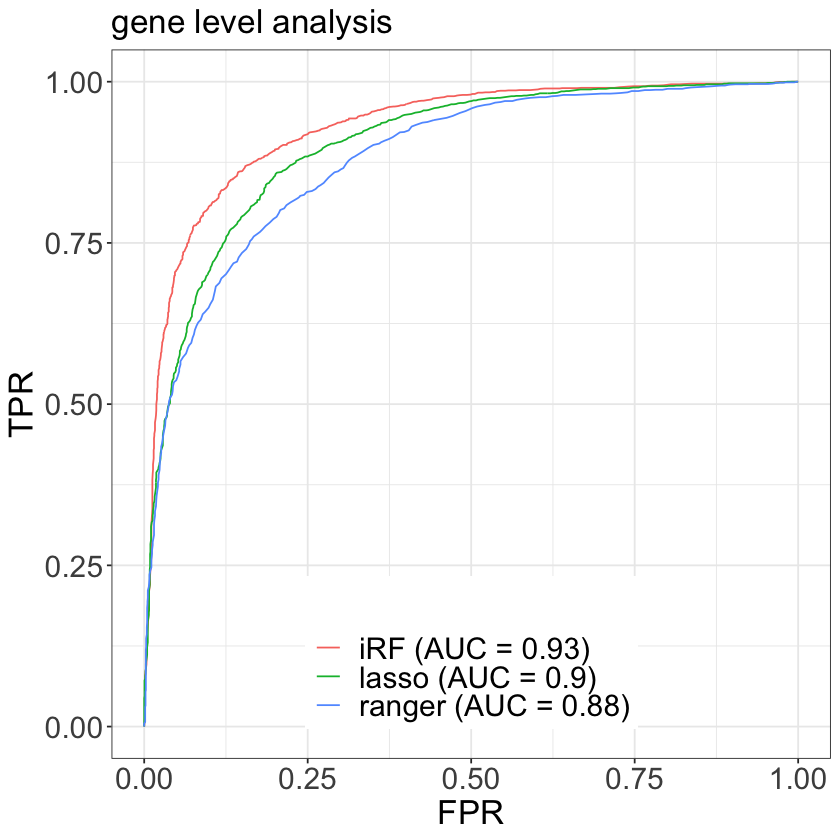

In [7]:
library(PRROC)

roc.curve.lasso.gene <- roc.curve(ypred.lasso[pheno == 1], ypred.lasso[pheno == 0], curve = TRUE)
roc.curve.ranger.gene <- roc.curve(ypred.ranger[pheno == 1], ypred.ranger[pheno == 0], curve = TRUE)
roc.curve.irf.gene <- roc.curve(ypred.irf[pheno == 1], ypred.irf[pheno == 0], curve = TRUE)

source("utilities_figures.R")

plot_gene <- plotCurve(list(roc.curve.lasso.gene, roc.curve.ranger.gene, roc.curve.irf.gene), 
            leg = c("lasso", "ranger", "iRF"), type = 'roc') +
    ggtitle("gene level analysis")

print(plot_gene)

In our analysis we only considered interactions that contain genes from different chromosomes and that have an iRF-stability score of at least 0.5, see reference [3] for details on this stability score. We can filter out those interactions as follows. 

In [8]:
source("utilities_general.R")

int <- cleanInt(fit$interaction$int)      #remove sign from interaction name
int <- sapply(int, function(x) unlist(str_split(x, '_')))     #individual genes in interaction
ind.db.int <- sapply(int, match, db.gene.chr.genename$gene)     #indexes of interaction genes in data base

ind.stab <- which(apply(fit$interaction, 1, function(x) all(x[10] >= 0.5)))     #indexes of interactions with stability score >= 0.5
ind.ichr <- which(sapply(ind.db.int, function(x) length(unique(db.gene.chr.genename$chr[x]))>1))     #indexes of interactions between different chromosomes  

print(fit$interaction[intersect(ind.stab, ind.ichr), ])

                                                                             int
 1:                                        ENSG00000003249.9+_ENSG00000101440.5+
 2:                                       ENSG00000101440.5+_ENSG00000185324.17-
 3:                                        ENSG00000101440.5+_ENSG00000258947.2-
 4:                     ENSG00000003249.9+_ENSG00000101440.5+_ENSG00000258947.2-
 5:                    ENSG00000003249.9+_ENSG00000101440.5+_ENSG00000185324.17-
 6:                                       ENSG00000181788.3-_ENSG00000185324.17-
 7:                    ENSG00000003249.9+_ENSG00000181788.3-_ENSG00000185324.17-
 8:                                        ENSG00000101440.5+_ENSG00000204991.6-
 9:                    ENSG00000101440.5+_ENSG00000185324.17-_ENSG00000258947.2-
10:                     ENSG00000003249.9+_ENSG00000101440.5+_ENSG00000204991.6-
11:                    ENSG00000101440.5+_ENSG00000185324.17-_ENSG00000204991.6-
12:                         

Note that iRF outputs signed interactions. In the following, we do not consider the sign, after removing the sign, the above 24 interactions reduce the 18 unsigned interactions.

## PCS p-values with CART models

For the iRF pre-filtered candidate interactions we obtained PCS p-values (see our manuscript for details) on the hold-out test data. We can load the p-value results as follows.

In [9]:
load("../results/pval_all_analysis_iRF_gene.Rdata")
load("../results/pval_analysis_iRF_gene.Rdata")

In order to reproduce the three-column summary figures from the paper, which show p-values, stability of significance (with Bonferoni correction) over bootstrap samples of the test data, and prediction error, for both null (no-epistasis) and alternative (epistasis) models, we first have to gather the relevant data into a single data frame.

In [10]:
library(tidyverse)

pval.info <- pValues.intra %>% select(genes, pC, stab.pCart) %>%
                rename(pval = pC, stab = stab.pCart) %>%
                add_column(logLA = sapply(pCart.intra, function(x) attr(x, "logLA")),
                   logLH = sapply(pCart.intra, function(x) attr(x, "logLH"))) 
                                     
head(pval.info)


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.2     ✔ readr   1.3.1
✔ tidyr   0.8.3     ✔ purrr   0.3.4
✔ tibble  2.1.2     ✔ forcats 0.4.0

Warning message:
“package ‘purrr’ was built under R version 3.6.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::count()     masks matrixStats::count()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



,genes,pval,stab,logLA,logLH
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,"DBNDD1 , ASIP",2.420638e-11,1.0,-2110.800,-2135.124
2,"ASIP , CDK10",1.000000e+00,0.0,-2433.021,-2411.509
3,"ASIP , TUBB3",1.105037e-04,0.8,-2032.333,-2039.228
4,"DBNDD1 , ASIP , TUBB3",1.000000e+00,0.0,-2093.501,-2032.333
5,"DBNDD1 , ASIP , CDK10",1.000000e+00,0.3,-1940.848,-1922.111
6,"SIAH2 , CDK10",1.000000e+00,0.0,-2418.772,-2418.736


Then we can generate the plots as follows.

Loading required package: rpart

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




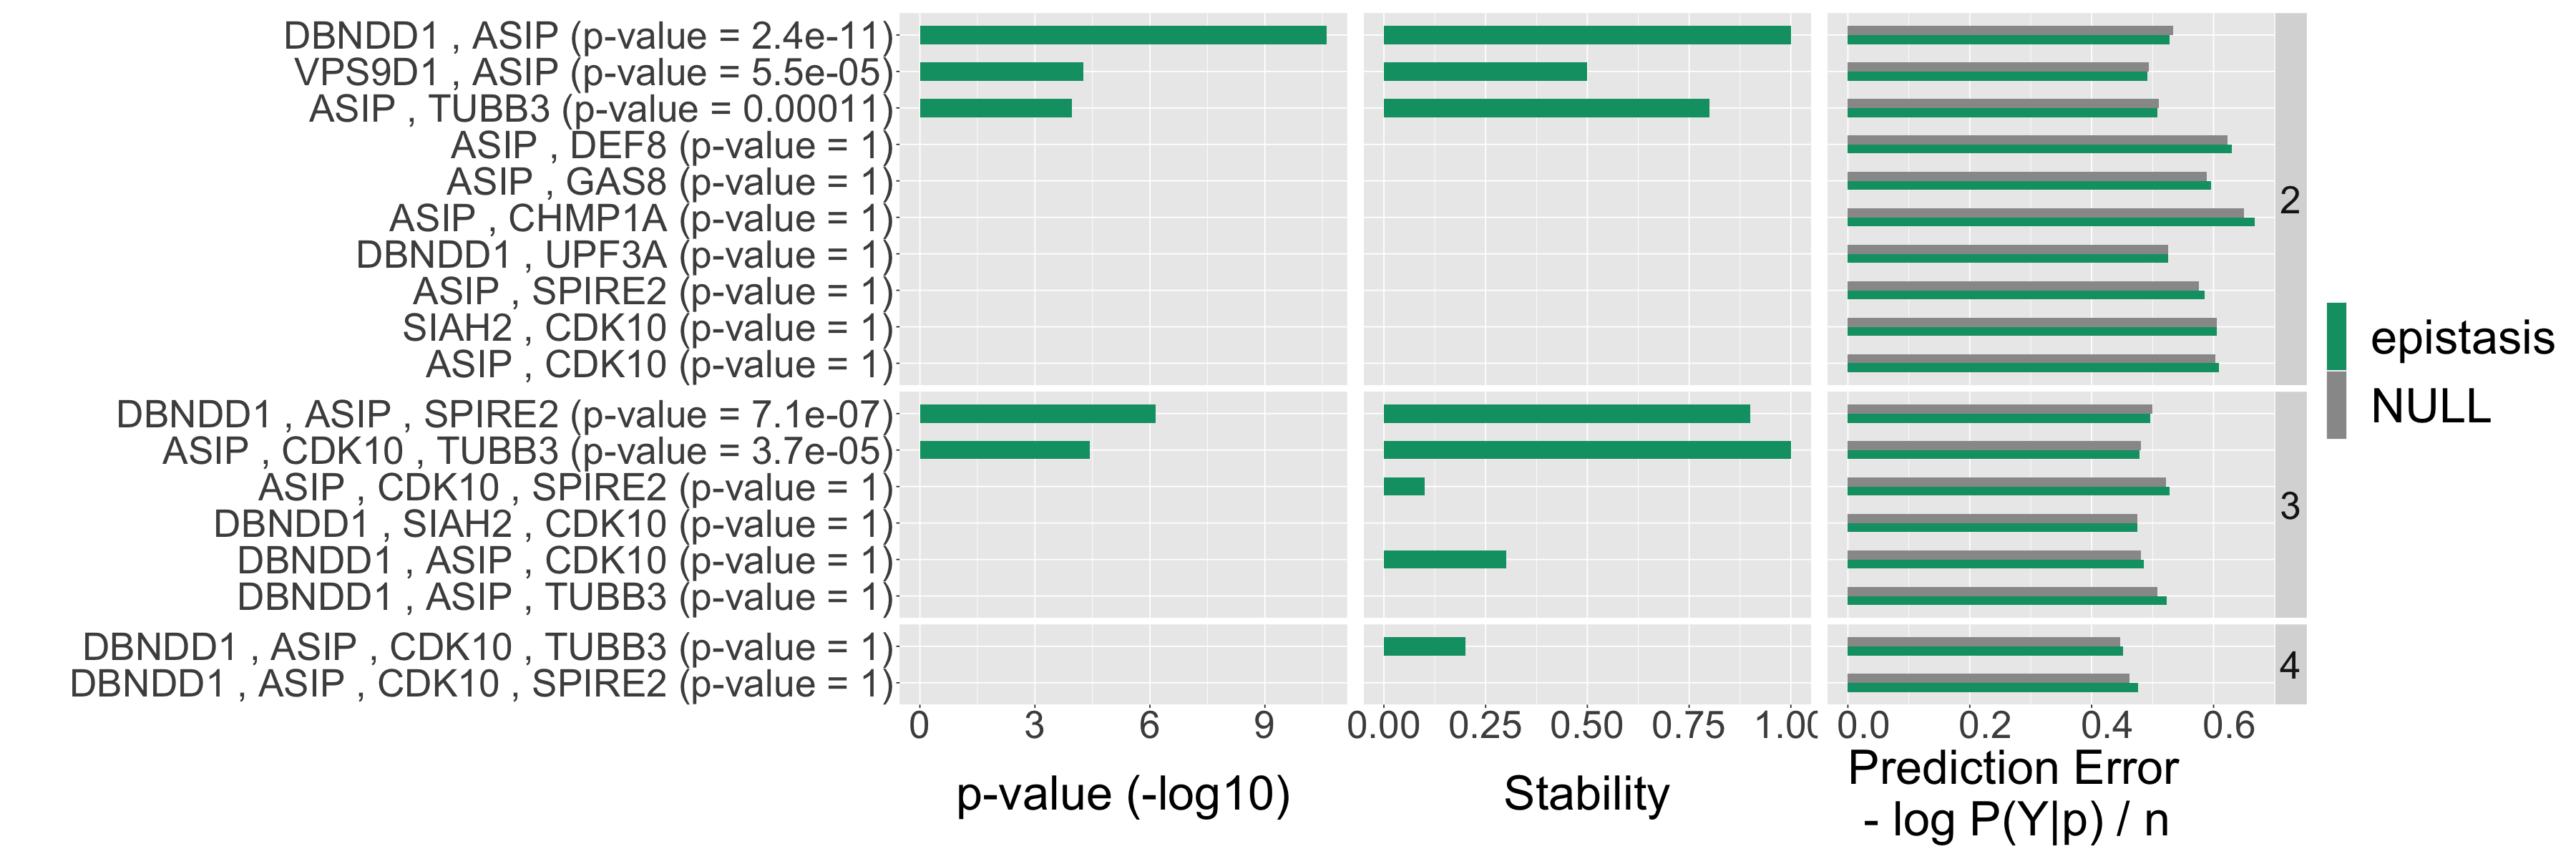

In [11]:
source("utilities_figures.R")

plot_pvalue_table <- plotPvalues(pval.info, n = length(pheno))

options(repr.plot.width=30, repr.plot.height=10)
print(plot_pvalue_table)

We can also look at individual response surfaces for the fitted CART models. All fitted CART models can be found in the folder *results/CART_models/*. As an example, we consider the interaction *ASIP - TUBB3*. Replace the file name to consider any other interaction. 

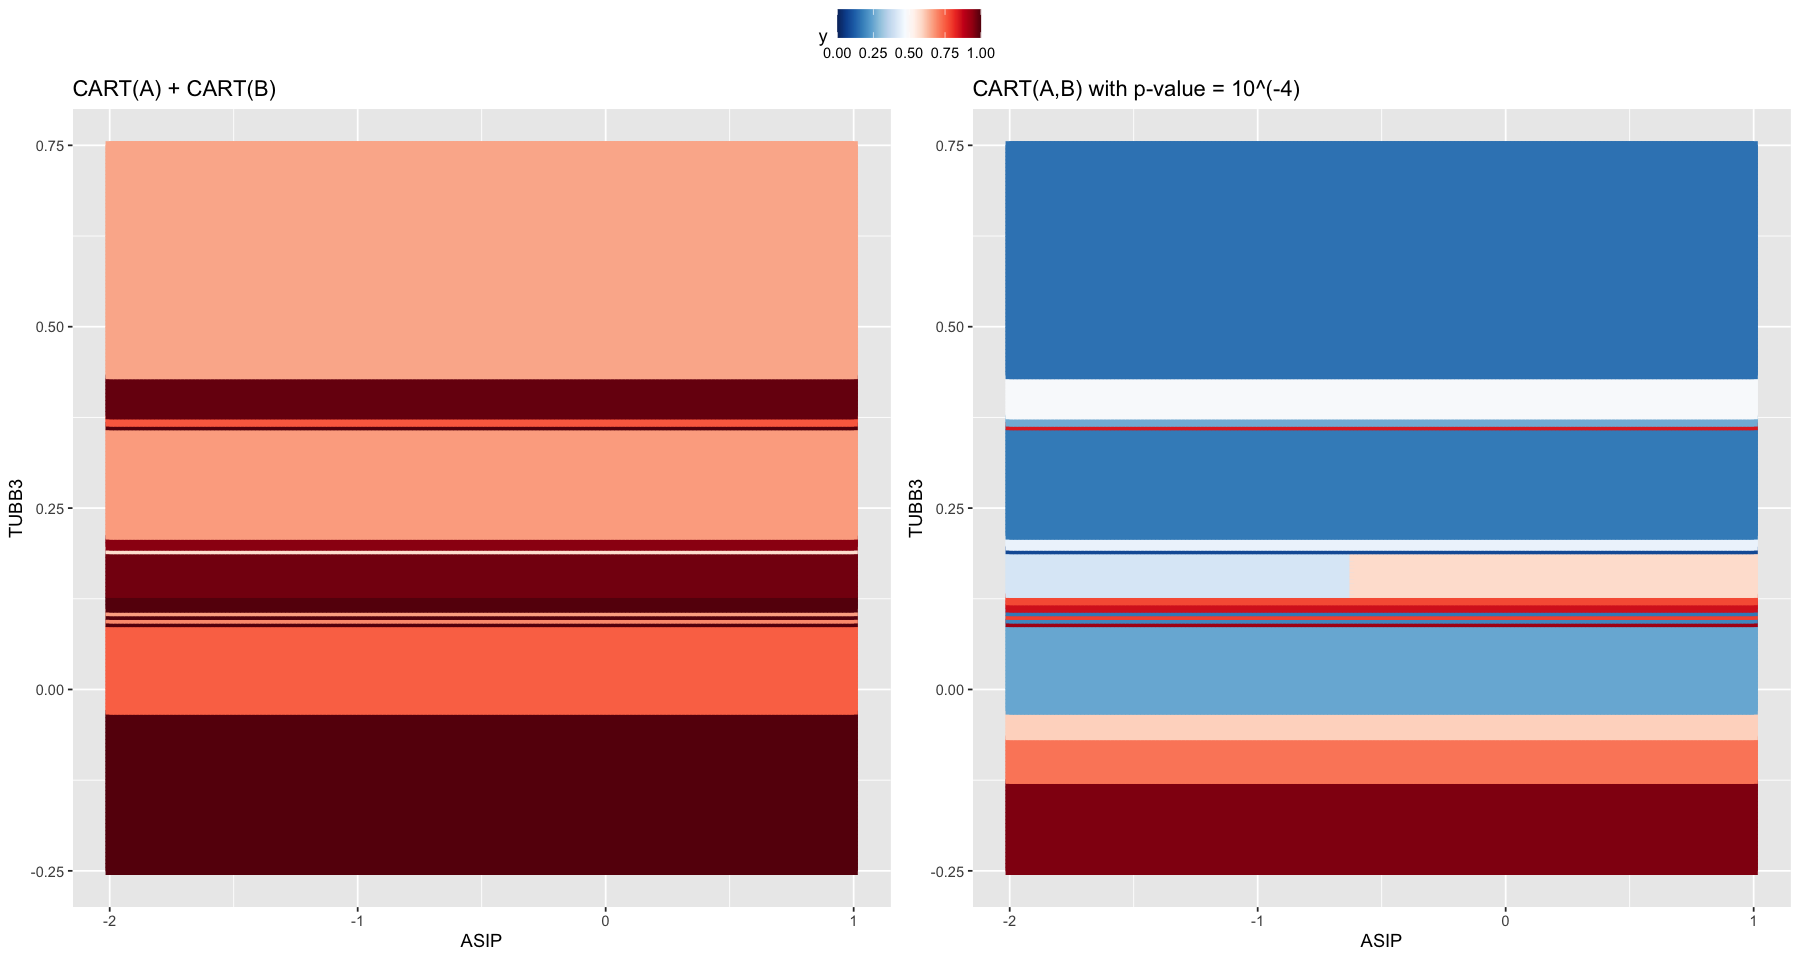

In [12]:
load("../results/CART_models/pval_cart_with_tree_analysis_iRF_gene_interaction_ASIP_TUBB3.Rdata")
source("utilities_figures.R")

plot_response <- plotResponse(pv, range1 = c(-2, 1), range2 = c(-0.25, 0.75))

options(repr.plot.width=15, repr.plot.height=8)
print(plot_response)

We can also plot the response surface together with some data, as is done for the test data in the manuscript. We demonstrate this with some randomly generated data below.

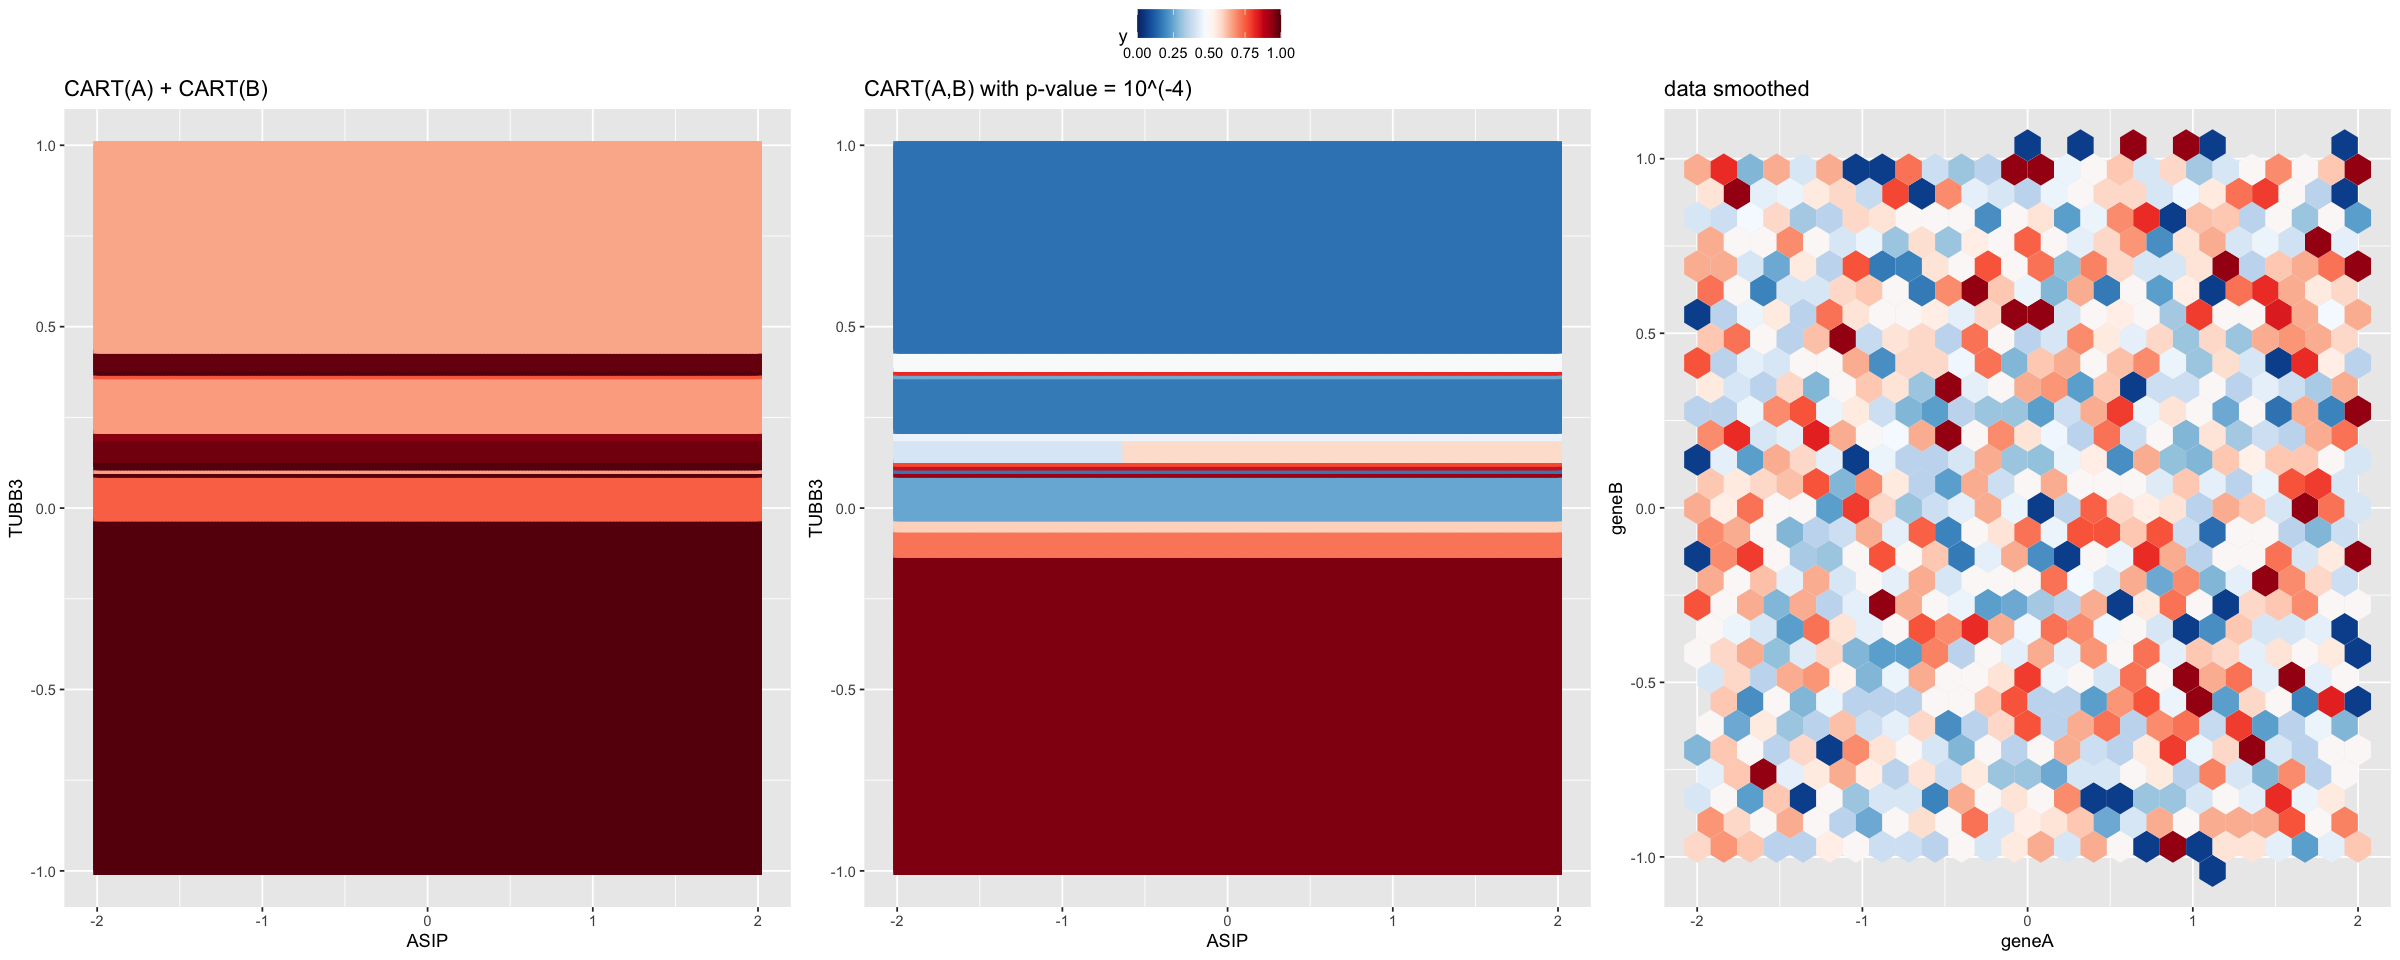

In [13]:
load("../results/CART_models/pval_cart_with_tree_analysis_iRF_gene_interaction_ASIP_TUBB3.Rdata")
source("utilities_figures.R")

n <- 5000
data <- list(geno = data.frame(geneA = runif(n,-2,2), geneB = runif(n,-1,1)), pheno = c(rep(1,n/2), rep(0,n/2)))

plot_response <- plotResponse(pv, data)

options(repr.plot.width=20, repr.plot.height=8)
print(plot_response)


Note that for the previous plot we did not specify range1 and range2 explicitly. In that case the range of the input data matrix is taken as a default range for the individual features. 

We can also use the *rpart.plot* R package to plot the corresponding tree structures of the model, as shown below.

Note that in this example, the additive model consists of only a single tree.

The additive tree model is centered at the mean.
For illustration purposes, for the tree(s) of the additive model we add back half of this mean value.

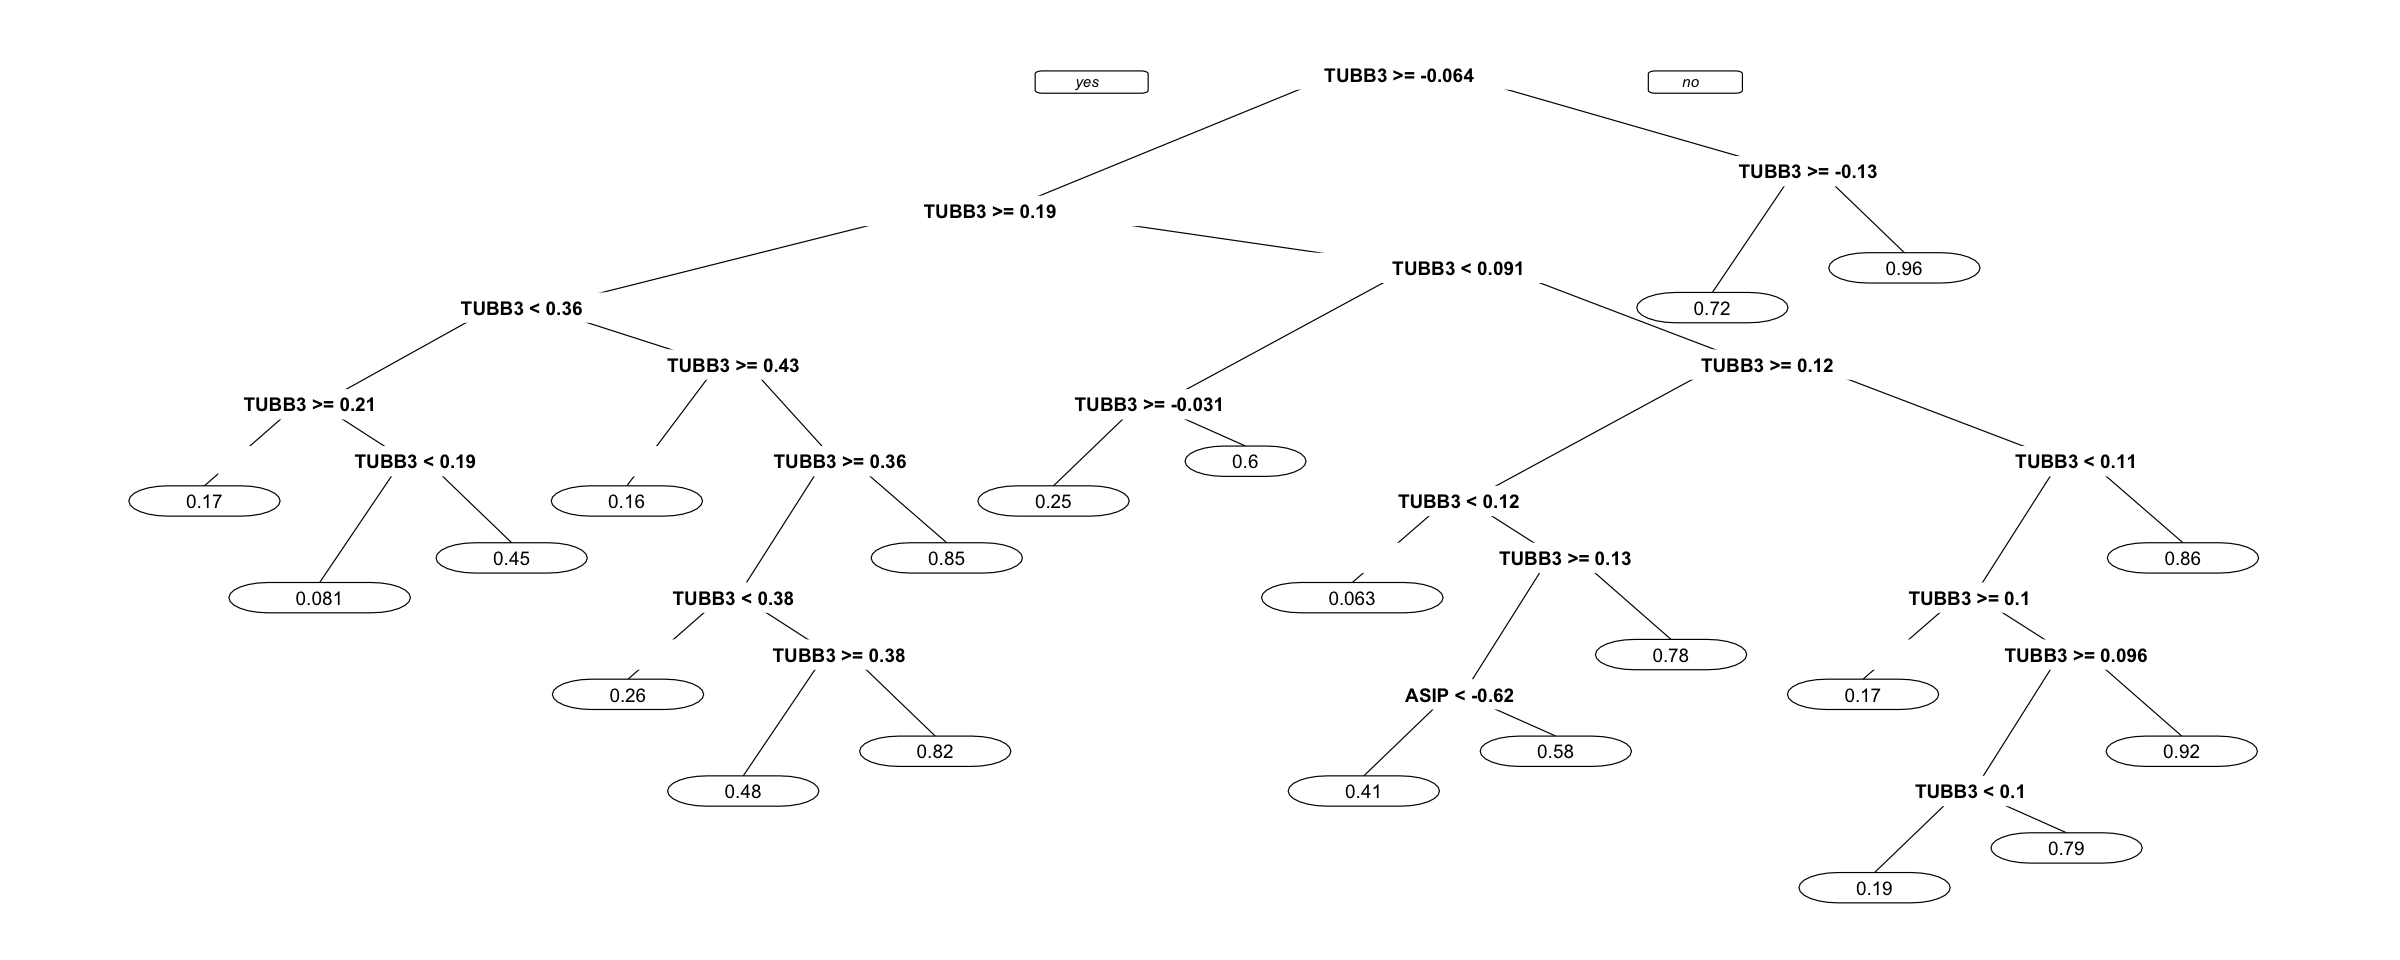

In [14]:
treeAB <- attr(pv, "treeA") # CART from the interaction model
treeA <- attr(pv, "treeH")[[1]] # CART from first feature
meanPheno <- attr(pv, "meanPheno")


treeA$frame$yval[which(treeA$frame$var == "<leaf>")] <- treeA$frame$yval[which(treeA$frame$var == "<leaf>")] + meanPheno/2

library(rpart.plot)

prp(treeAB, roundint=FALSE)

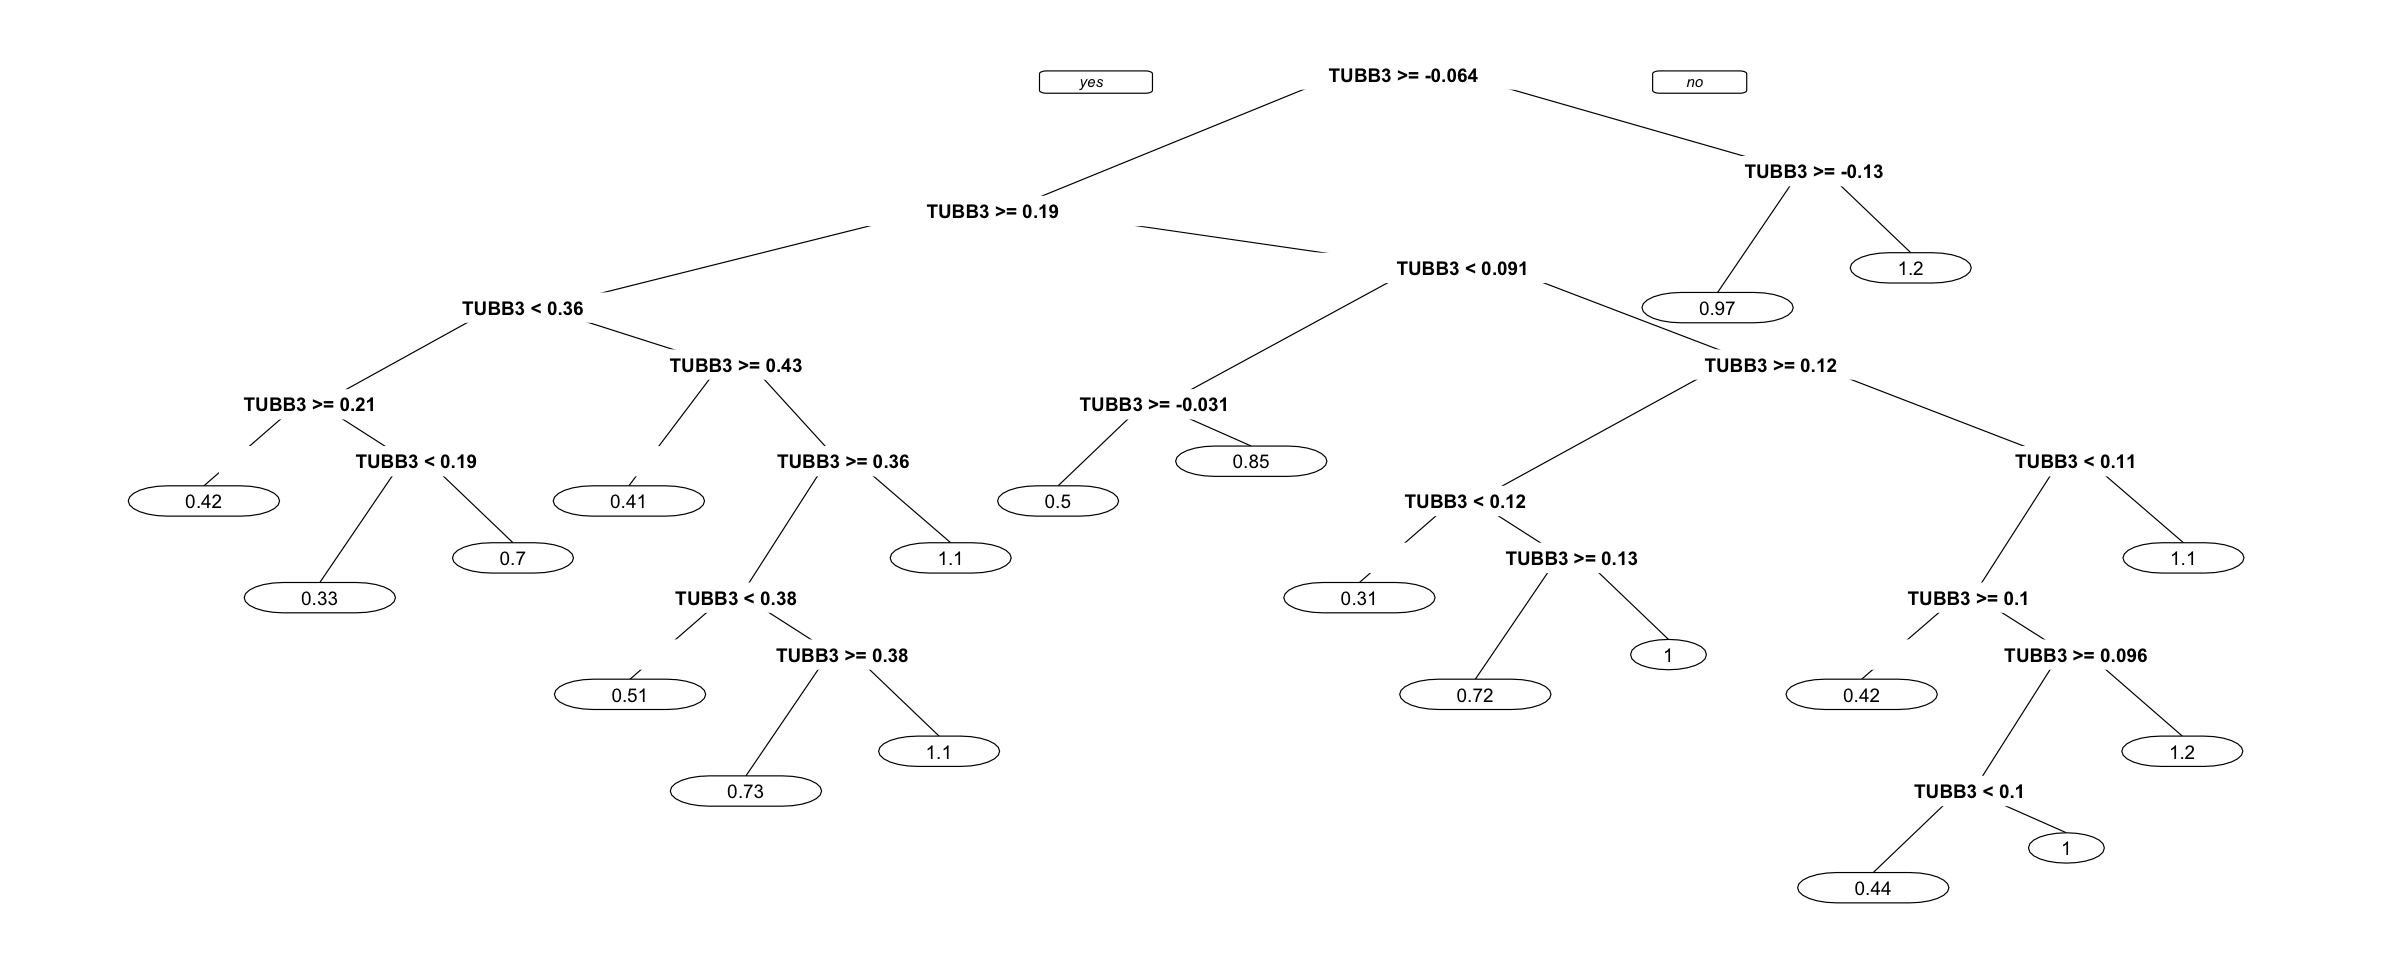

In [15]:
prp(treeA, roundint=FALSE)